In [1]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

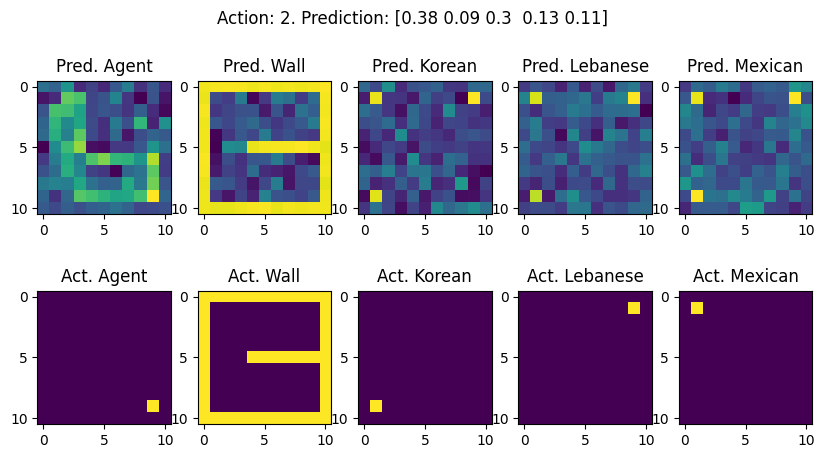

In [2]:
%autoreload 2
# from examples.ft.test import eval_model

# results = eval_model(
#     'memories',
#     model_path='../models/checkpoints/model_iRainbowModel_0.0_5.pkl',
#     config_path='../config.yaml',
#     n_games=1000
# )

# results['memories'].save('../models/checkpoints/memories.pkl')

import argparse
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

from examples.ft.utils import fig2img, animate
from examples.ft.env import FoodTrucks
from examples.ft.models.inverse import MLPBCModel
from examples.ft.models.buffer import ActionBatchReplayBuffer as ABRBuffer
from examples.ft.config import load_config, create_agents, create_entities, create_models, Cfg

# ------------------------------------------------------ #
# region: Create the forward model for the animations... #
# ------------------------------------------------------ #

cfg = load_config(argparse.Namespace(config='../config.yaml'))
models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = FoodTrucks(cfg, agents, entities)

# ------------------------------------------------------ #
# endregion                                              #
# ------------------------------------------------------ #


memories = ABRBuffer.load('../models/checkpoints/memories.pkl')
inverse_model = MLPBCModel(
    state_size=[7, 11, 11],
    action_size=5,
    layer_size=10000,
    epsilon=0.,
    n_channels=7,
    frames=5,
    seed=np.random.randint(0,1000),
    device='cpu',
    memory=memories,
    LR=.000001
)

losses = []

action_model_store = ABRBuffer(
    buffer_size=cfg.experiment.max_turns,
    batch_size=cfg.experiment.max_turns,
    device=None,
    seed=None,
    gamma=None,
    timesteps=5,
    action_space=5
)

for i in range(100000):

    action_loss, reconstruction_loss = inverse_model.train_model()
    if i % 50 == 0:
        clear_output(wait = True)

        # ----------------- #
        # region: Game loop #
        # ----------------- #

        env.reset()
        for agent in agents:
            agent.reset()
            # Load model checkpoint
            agent.model.load('../models/checkpoints/model_iRainbowModel_0.0_5.pkl')
            # Zero out model epsilon
            agent.model.set_epsilon(0)
            # Evaluation mode
            agent.model.eval()

        done, turn = 0, 0

        while done == 0:

            # ----------------- #
            # region: Turn loop #
            # ----------------- #

            for agent in agents:

                state, action, reward, next_state, done_ = agent.transition(env)

                # If agent finished or max turns is reached, end the turn
                if turn >= cfg.experiment.max_turns or done_: 
                    done = 1 # End loop if maximum turns have been reached
                
                # Append the experience to the replay
                exp = (0, (state, action, reward, next_state, done))
                agent.episode_memory.append(exp)
                action_model_store.add(state, action, reward, next_state, done)

            # ----------------- #
            # endregion         #
            # ----------------- #

        frames = []

        while len(action_model_store.memory) > 0:

            experience = action_model_store.memory.popleft()
            state, action, _, _, _ = experience

            clear_output(wait = True)
            fig = inverse_model.plot_images(state, action.squeeze())
            img = fig2img(fig)
            plt.show()
            frames.append(img)

        animate(frames,
                f'inverse_model_{i}.png',
                '../data/')
                    
        # ----------------- #
        # endregion         #
        # ----------------- #
        

        
        



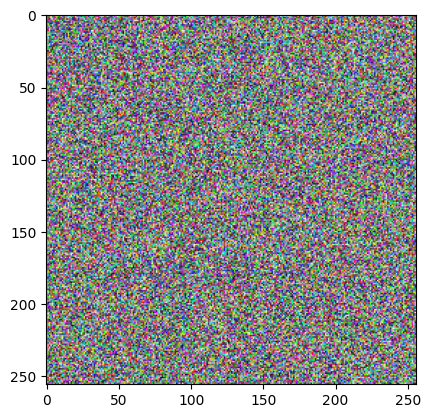

In [ ]:
import torch
from torchvision import datapoints
from matplotlib import pyplot as plt

t = torch.rand(3, 256, 256)
i = datapoints.Image(t)

plt.imshow(i.permute(1, 2, 0))
plt.show()

range(0, 2)